# Attention Mechanism from Scratch

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
Biological sequences can be viewed as text and therefore analyzed using Natural Language Processing (NLP) techniques. In this notebook, I will compare text generation via Attention mechanism, underlying some Large Language Models (LLM) such as ChatGPT, with more traditional Markov Chain and Long Short Term Memory (LSTM) techniques. I will concentrate on deriving and coding attention mechanism from scratch and explaining its principles.

### Table of Contents:
* [Background and motivation for Computational Biology](#Background-and-motivation-for-Computational-Biology)
* [Text generation with Markov Chain](#Text-generation-with-Markov-Chain)
* [Text generation with LSTM](#Text-generation-with-LSTM)
* [Explaining and programming Attention mechanism from scratch](#Explaining-and-programming-Attention-mechanism-from-scratch)
* [Text generation with LSTM with Attention layer](#Text-generation-with-LSTM-with-Attention-layer)

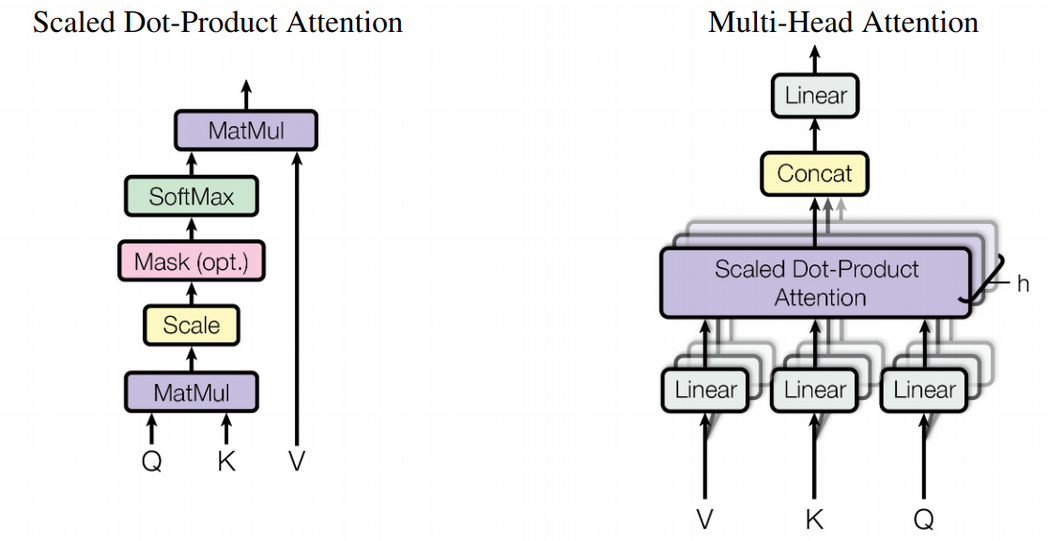

In [1]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/attention.png', width = 1000)

### Background and motivation for Computational Biology  <a class="anchor" id="Background-and-motivation-for-Computational-Biology"></a>

Analysis of text data is of great interest for Computational Biology because biological sequences (DNA, RNA, proteins etc.) can be viewed as a text.

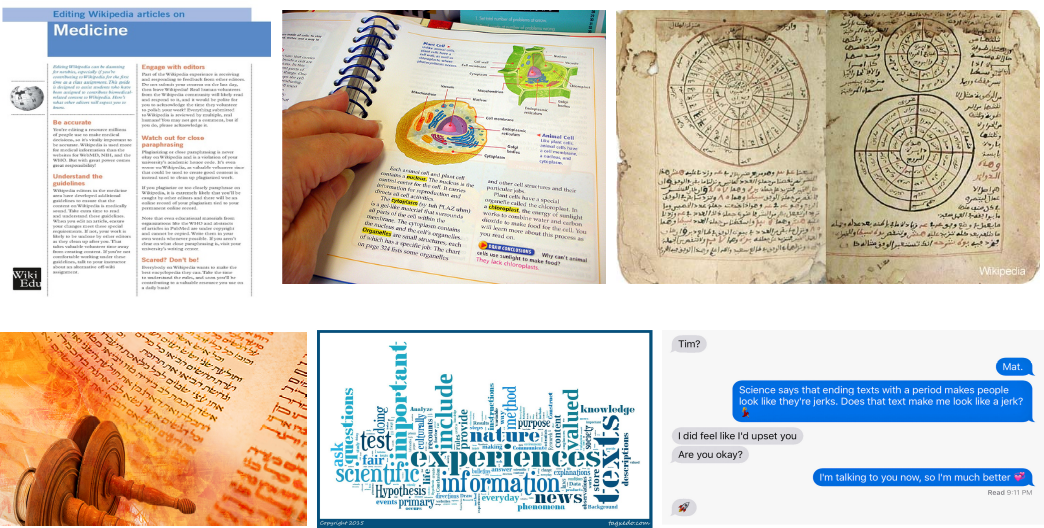

In [2]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/texts.png', width = 1000)

In the DNA sequence below, blue segments are gene regions and the red segements are intergenic regions.

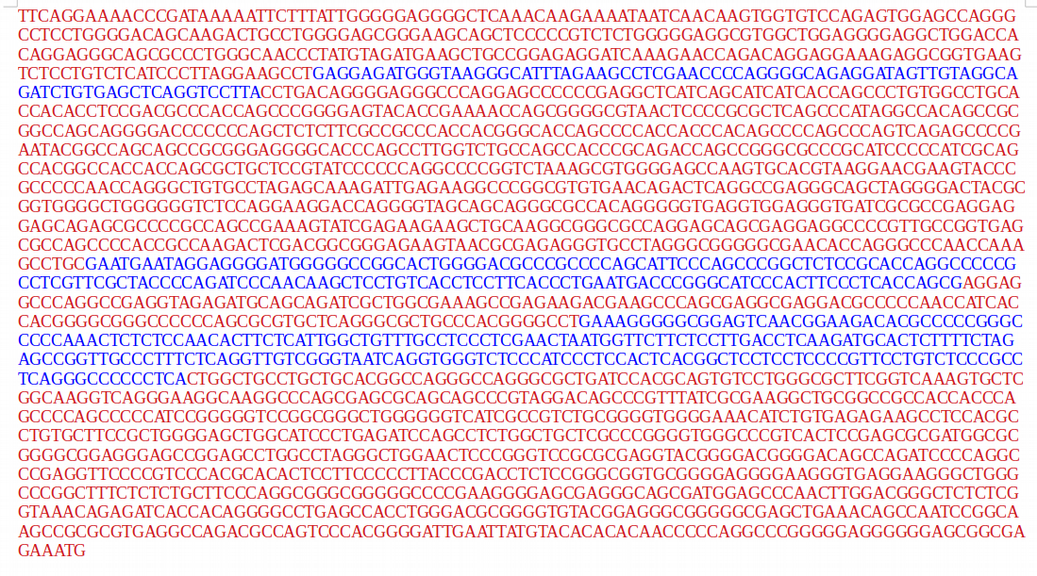

In [3]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/dna.png', width = 1000)

A good old way of detecting gene regions is the [Hidden Markov Model (HMM)](https://en.wikipedia.org/wiki/Hidden_Markov_model), which is based on the concepts of transition and emission probabilities. Briefly, using annotated sets of genic and intergenic sequences and counting how many times A, C, G and T nucleotides are observed in each set, one can compute the **emission matrix**. Then, one can define a **transition matrix** via probabilities of changing between genic and intergenic states.

In [4]:
import numpy as np
import pandas as pd


emission = pd.DataFrame(np.array([[0.2910406, 0.2084386, 0.2086294, 0.2918914], 
                                  [0.3089565, 0.1911851, 0.1911704, 0.3086880]]), 
                        columns = ["A", "C", "G", "T"], index = ["Gene", "NotGene"])
emission

A         C         G         T
Gene     0.291041  0.208439  0.208629  0.291891
NotGene  0.308957  0.191185  0.191170  0.308688

In [5]:
transition = pd.DataFrame(np.array([[0.59, 0.41], [0.40, 0.60]]), 
                          columns = ["Gene", "NotGene"], index = ["Gene", "NotGene"])
transition

Gene  NotGene
Gene     0.59     0.41
NotGene  0.40     0.60

Finally, the **Viterbi algorithm**, which is the main HMM algorithm, uses a product of the emission and transition matrices in order to infer whether a certain sequence belongs to gene or intergenic region.

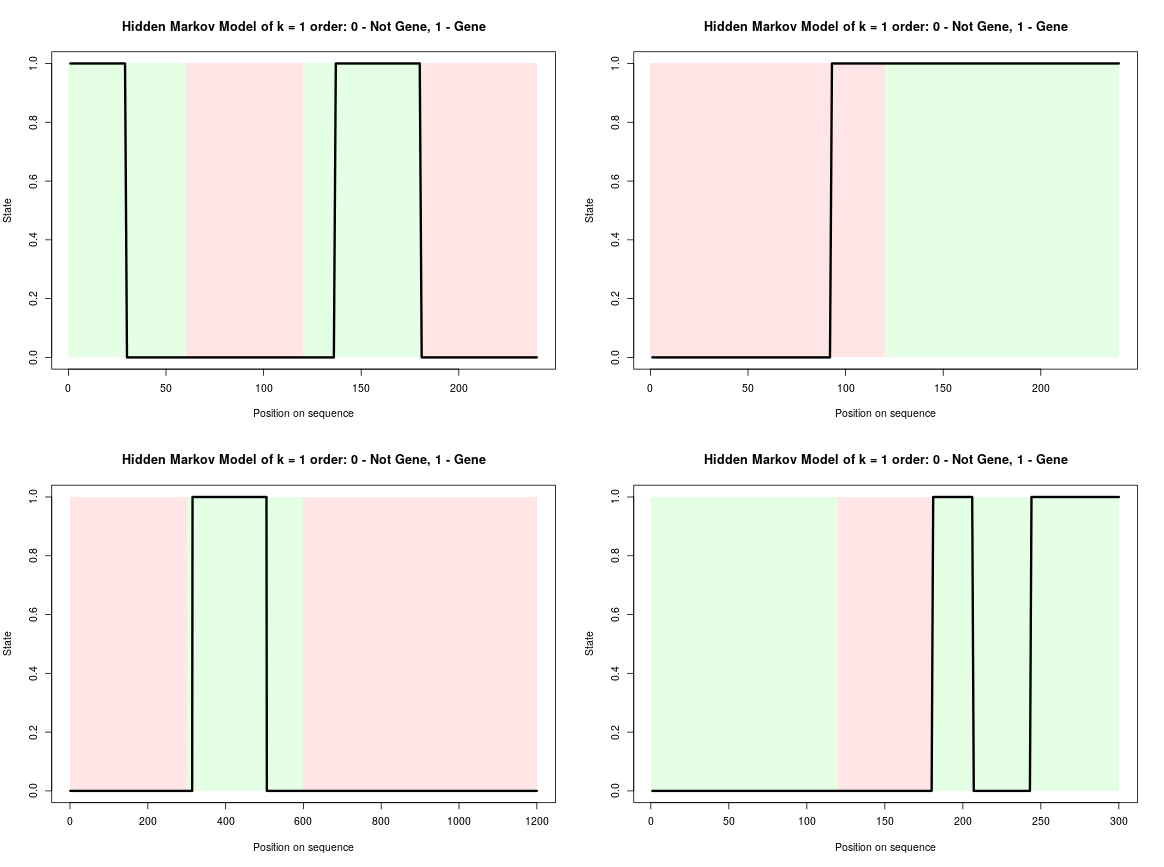

In [6]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/HMM_gene_prediction.png', width = 1000)

Similarly one can use the concept of Markov Chain and transition matrix for generating a DNA sequence. Below we compute the Markov Chain transition matrix which holds the probabilities of observing any of the four nucleotide, i.e. A, C, G and T, after each of the four nucleotide. Also, please note that the interpretation of Markov Chain transition matrix is slightly different from HMM transition matrix above.

In [7]:
markov_chain_transition = pd.DataFrame(np.array([[0.30, 0.20, 0.30, 0.20], 
                                                 [0.25, 0.25, 0.25, 0.25], 
                                                 [0.25, 0.25, 0.25, 0.25], 
                                                 [0.20, 0.20, 0.30, 0.30]]), 
                                       columns = ["A", "C", "G", "T"], index = ["A", "C", "G", "T"])
markov_chain_transition

A     C     G     T
A  0.30  0.20  0.30  0.20
C  0.25  0.25  0.25  0.25
G  0.25  0.25  0.25  0.25
T  0.20  0.20  0.30  0.30

Now, given an initial nucleotide, we can draw next nucleotides from multinomial (4-classes: A, C, G and T) distribution, and generate a nucleotide sequence of certain length as a Markov Chain.

In [8]:
current_nuc = 'C'
nucs = ["A", "C", "G", "T"]
next_nuc_list = []
for i in range(100): 
    next_nuc = np.array(nucs)[np.random.multinomial(1, list(markov_chain_transition.loc[current_nuc, :])) == 1][0]
    current_nuc = next_nuc
    next_nuc_list.append(next_nuc)

''.join(next_nuc_list)

'TGTGCATTGTGCCTCAGGGCATGACTGACACCCAGTGCCGGGGAGTGATTTTATAGAGCTCATTTAGCGTGAGTCGCCTTCCTATATGAAACTCAGCTGA'

The obtained nucleotide sequence should have nucleotide and dinucleotide frequencies similar to the real human DNA.

Finally, before going further, let us ask: if DNA sequence is a text, what would be then the words? It turns out that **k-mers** can be considered as words, i.e. building block of the DNA sentence / sequence. Indeed, sliding a window of a fixed size (k-mer size) along the DNA sequence of length L, we can represent it as L-k+1 words, which we for convienicence separate with spaces, see the figure below. Then words / k-mer frequencies can be used  for a **sentiment-like analysis**, i.e. comparision of word / k-mer usage between case and control DNA, as in the **Bag of Words** NLP method.

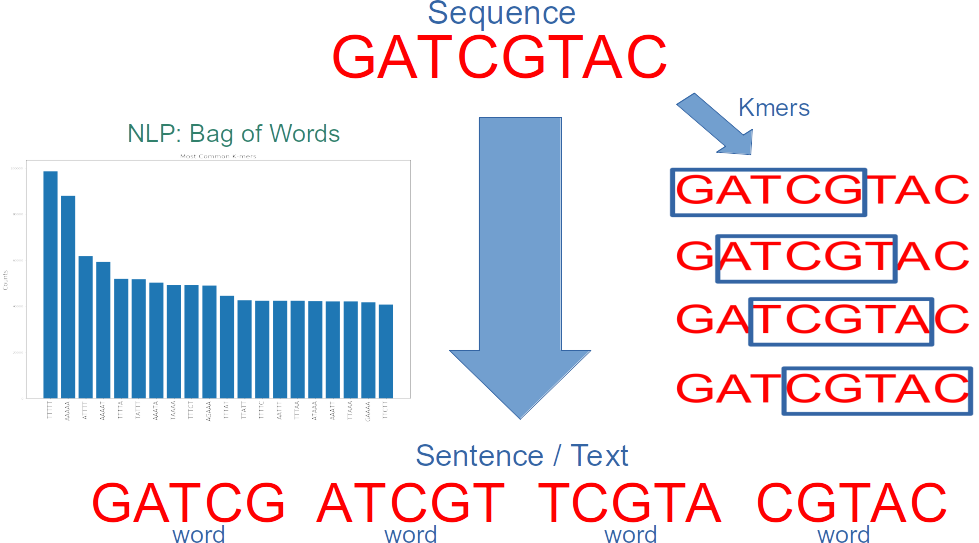

In [5]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/kmers.png', width = 1000)

Also, the words / k-mers can be represented as numeric vectors of arbitrary length (so-called Embeddings, which can be achieved with a trained Embeddings layer of a neural network) as it is implemented in the **Word2Vec** pre-trained NLP model which can also keep some relation by semntics between the words.

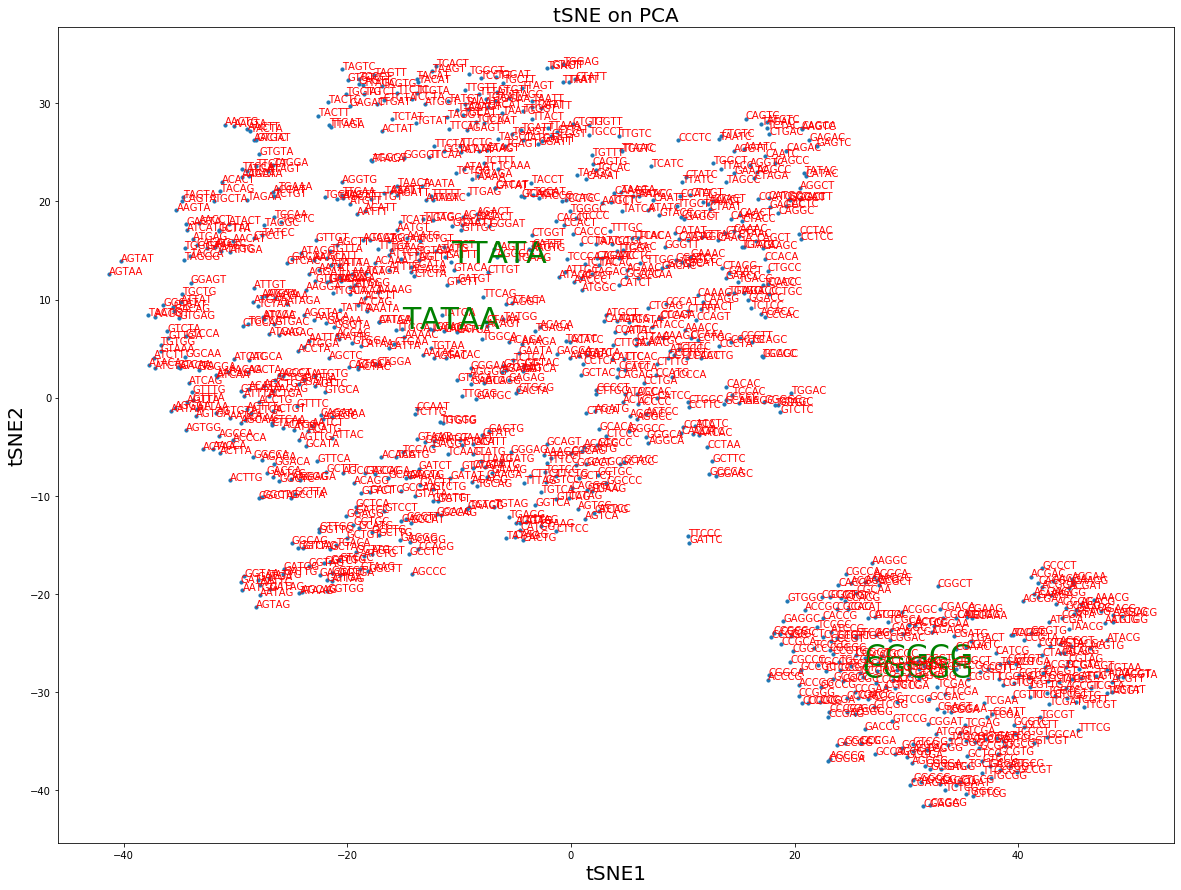

In [6]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/tSNE_kmers.png', width = 1000)

In the tSNE plot above, the words / k-mers are visualized in 2D space, where it is clear that AT-rich and GC-rish k-mers form two distinct clusters. Please keep in mind this possibility to encode words / k-mers as embedding vectors, we will use this later when explaining the concept of Attention.

### Text generation with Markov Chain  <a class="anchor" id="Text-generation-with-Markov-Chain"></a>

Now, after we have explained the relevance of textual data analysis for Computational Biology, and demonstrated how a DNA sequence can be generated from Markov process given transition matrix, let us exercise a bit with real texts. In this section we will demonstrate how to generate text with a simple **short-memory** process such as Markov Chain that remembers only the previous word in a text. For demonstration purposes, we will be using the text from the first part of "Crime and Punishment" novel by Fedor Dostoevsky, which can be copied from the [Gutenberg project](https://www.gutenberg.org/files/2554/2554-h/2554-h.htm).

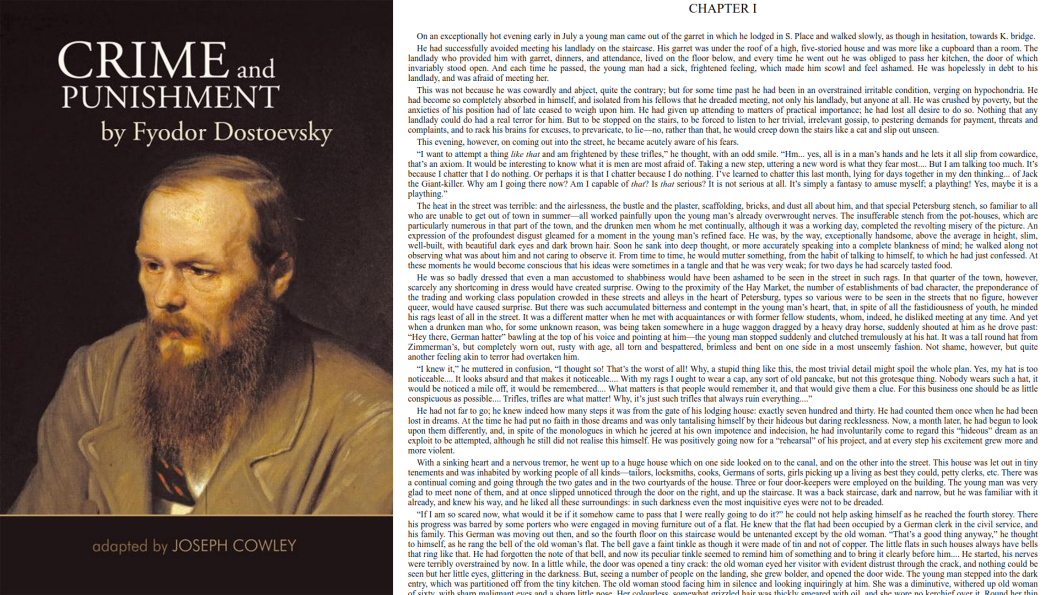

In [9]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/dostoevsky.png', width = 1000)

We can use the whole text, but to properly visualize the transition matrix it is helpful to start with just one (not even compete) sentence.

In [1]:
import numpy as np
import pandas as pd

sentence = 'The landlady who provided him with garret, dinners, and attendance, lived on the floor \
below, and every time he went out he was'
sentence

#sentence = 'The landlady who provided him with garret, dinners, and attendance, lived on the floor \
#below, and every time he went out he was obliged to pass her kitchen, the door of which invariably stood open'

#sentence = open('crime_and_punishment.txt', encoding = 'utf8').read()
#sentence[0:1000]

'The landlady who provided him with garret, dinners, and attendance, lived on the floor below, and every time he went out he was'

In [2]:
tokens = sentence.split()
tokens[0:8]

['The', 'landlady', 'who', 'provided', 'him', 'with', 'garret,', 'dinners,']

After we have tokenized the sentence (please note that since we are aiming at text generation, in contrast to a typical NLP pre-processing, we are not going to remove punctution and stop words and use lemmatization), we can create a transition matrix by counting for each word, how many times one word follows another word. Then, after per word normalization by the total sum of observed word pairs, we get the transition matrix below, where the elements have an interpretation of probabilities of observing two words in a certain order.

In [3]:
transition_matrix = np.zeros((len(tokens), len(tokens)))

for i in range(len(tokens)-1):
    transition_matrix[i, (i + 1)] += 1
    
transition_df = (pd.DataFrame(transition_matrix, index = tokens, columns = tokens)).T
transition_df = transition_df.groupby(transition_df.columns, axis = 1).sum()
transition_df = transition_df.div(transition_df.sum(), axis = 1)
transition_df = transition_df.fillna(0)
transition_df

The  and  attendance,  below,  dinners,  every  floor  garret,  \
The          0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
landlady     1.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
who          0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
provided     0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
him          0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
with         0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
garret,      0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
dinners,     0.0  0.0          0.0     0.0       0.0    0.0    0.0      1.0   
and          0.0  0.0          0.0     0.0       1.0    0.0    0.0      0.0   
attendance,  0.0  0.5          0.0     0.0       0.0    0.0    0.0      0.0   
lived        0.0  0.0          1.0     0.0       0.0    0.0    0.0      0.0   
on           0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
the          0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
floor        0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
below,       0.0  0.0          0.0     0.0       0.0    0.0    1.0      0.0   
and          0.0  0.0          0.0     1.0       0.0    0.0    0.0      0.0   
every        0.0  0.5          0.0     0.0       0.0    0.0    0.0      0.0   
time         0.0  0.0          0.0     0.0       0.0    1.0    0.0      0.0   
he           0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
went         0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
out          0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
he           0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   
was          0.0  0.0          0.0     0.0       0.0    0.0    0.0      0.0   

              he  him  ...  lived   on  out  provided  the  time  was  went  \
The          0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
landlady     0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
who          0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
provided     0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
him          0.0  0.0  ...    0.0  0.0  0.0       1.0  0.0   0.0  0.0   0.0   
with         0.0  1.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
garret,      0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
dinners,     0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
and          0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
attendance,  0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
lived        0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
on           0.0  0.0  ...    1.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
the          0.0  0.0  ...    0.0  1.0  0.0       0.0  0.0   0.0  0.0   0.0   
floor        0.0  0.0  ...    0.0  0.0  0.0       0.0  1.0   0.0  0.0   0.0   
below,       0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
and          0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
every        0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
time         0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
he           0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   1.0  0.0   0.0   
went         0.5  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   
out          0.0  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   1.0   
he           0.0  0.0  ...    0.0  0.0  1.0       0.0  0.0   0.0  0.0   0.0   
was          0.5  0.0  ...    0.0  0.0  0.0       0.0  0.0   0.0  0.0   0.0   

             who  with  
The          0.0   0.0  
landlady     0.0   0.0  
who          0.0   0.0  
provided     1.0   0.0  
him          0.0   0.0  
with         0.0   0.0  
garret,      0.0   1.0  
dinners,     0.0   

In [4]:
transition_df.shape

(23, 21)

Please note that all words but "and" and "he" have only one following word. In contrast, the word "and" can have two following words: "attendance," and "every", while "he" can have "went" and "was" with 50% chance of observing them following "he". Now, given the transition matrix, we can specify an initial word (for example, "provided"), and randomly draw next words from the multinomial 21-class distribution, similarly to the way we previously generated the nucleotide sequence.

In [5]:
N_words = 10
current_w = 'provided'
markov_chain = [current_w]
for i in range(N_words):
    next_w = np.array(tokens)[np.random.multinomial(1, list(transition_df.loc[:, current_w])) == 1][0]
    markov_chain.append(next_w)
    current_w = next_w

In [6]:
' '.join(markov_chain)

'provided him with garret, dinners, and every time he went out'

We get almost a perfect text, especially in the beginning. However, please note how the meaning has slightly changed starting from the word "and". More specifically, instead of "... with garret, diners, **and attendance** ...", the sentance flipped to "... with garret, diners, **and every** time ...". This is because the Markov Chain had 50% chance to select either "attendance" (perfect match) or "every" (sub-optimal), and it selected "every". However, providing more text would likely improve the performance as it will be more and more obvious which word (i.e. "attendance" or "every") is more typical in this context. The counts in the transition matrix will grow with the amount of text.

### Text generation with LSTM  <a class="anchor" id="Text-generation-with-LSTM"></a>

In this section, we will demonstrate how to generate text with an **LSTM neural network** which presumably has a **longer memory** and can generate more meaningful texts. The design of LSTM was borrowed from materials avilable [here](https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms) and [here](https://towardsdatascience.com/nlp-text-generation-through-bidirectional-lstm-model-9af29da4e520). Again, for simplicity and more accurate comparison with the Markov Chain text generator, we will use not the whole text from part 1 of "Crime and Punishment" (we can if we want!) but only first three paragraphs with only a few of sentences.

In [1]:
import numpy as np
data = open('crime_and_punishment.txt').read()
corpus = data.lower().split("\n")
corpus = corpus[0:5]
corpus

['on an exceptionally hot evening early in july a young man came out of the garret in which he lodged in s. place and walked slowly, as though in hesitation, towards k. bridge.',
 '',
 'he had successfully avoided meeting his landlady on the staircase. his garret was under the roof of a high, five-storied house and was more like a cupboard than a room. the landlady who provided him with garret, dinners, and attendance, lived on the floor below, and every time he went out he was obliged to pass her kitchen, the door of which invariably stood open. and each time he passed, the young man had a sick, frightened feeling, which made him scowl and feel ashamed. he was hopelessly in debt to his landlady, and was afraid of meeting her.',
 '',
 'this was not because he was cowardly and abject, quite the contrary; but for some time past he had been in an overstrained irritable condition, verging on hypochondria. he had become so completely absorbed in himself, and isolated from his fellows that h

Please note that we are not going to remove punctuation, stop words, and do stemming and lemmatization, i.e. we are not following the standard NLP text pre-processing steps. This is because our task is text generation, which does not require extensive cleaing of the input text.

Text generation requires a **sequence input data**, as given a sequence (of words / tokens) **the aim is the predict next word / token**. 

Next, we need to **tokenize** our corpus. Tokenization is a process of extracting tokens (terms / words) from a corpus and encoding them as numbers. One can either manually tokenize the corpus or use special tool available at NLTK and Keras libraries. Keras has inbuilt model *Tokenizer* for tokenization which can be used to obtain the tokens and their index in the corpus.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

total_words

162

We can see that we have more then hundred fifty words in the three first paragraphs of "Crime and Punishment". Now, once *Tokenizer* has been applied to the corpus, it can provide multiple outputs such as word counts, co-occurence matrix etc. Here, however, we are interested in one particular form of text which is a sequence of tokens, i.e. the corpus will be represented as a list of lists (one lists per sentence) where each word was converted into an integer.

In [3]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
input_sequences[0:10]

[[11, 23],
 [11, 23, 34],
 [11, 23, 34, 35],
 [11, 23, 34, 35, 36],
 [11, 23, 34, 35, 36, 37],
 [11, 23, 34, 35, 36, 37, 7],
 [11, 23, 34, 35, 36, 37, 7, 38],
 [11, 23, 34, 35, 36, 37, 7, 38, 8],
 [11, 23, 34, 35, 36, 37, 7, 38, 8, 24],
 [11, 23, 34, 35, 36, 37, 7, 38, 8, 24, 25]]

In the above output, **[11, 23], [11, 23, 34], [11, 23, 34, 35]** and so on represent the **N-gram phrases** generated from the input text data, where every integer corresponds to the index of a particular word in the complete vocabulary of words present in the text. we need to prepare the data in this way as N-grams for the particular task of text generation. Later, we will use the last word as a label, and all the words prior the last word as data. Therefore, the task will be to use all the words prior the last word in order to predict the last word in a sentence.

After this step, every text document in the dataset is converted into sequence of tokens. Now that we have generated a data-set which contains sequence of tokens, it is possible that different sequences have different lengths. Therefore, before starting training the model, we need to pad the sequences and make their lengths equal. We can use pad_sequence function of Kears for this purpose. 

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
input_sequences

array([[  0,   0,   0, ...,   0,  11,  23],
       [  0,   0,   0, ...,  11,  23,  34],
       [  0,   0,   0, ...,  23,  34,  35],
       ...,
       [  0,   0,  92, ..., 159,   3, 160],
       [  0,  92,   6, ...,   3, 160,  16],
       [ 92,   6,  28, ..., 160,  16, 161]], dtype=int32)

To input this data into a learning model, we need to create predictors and label. We will create **N-grams sequence as predictors and the next word of the N-gram as label**.

In [5]:
import tensorflow.keras.utils as ku

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes = total_words)
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let us build a *Sequential* Keras model with the first layer as the word *Embedding* layer. Then, we will apply a bidirectional LSTM layer of neural net, where parameter *return_sequence* is marked as *True* so that the word generation keeps in consideration previous and the words coming ahead in the sequence. A dropout layer is added to avoid overfitting, one more LSTM layer and, one more dense layer with activation as Relu, and a regularizer to avoid over-fitting again are then added. The output layer has softmax so as to get the probability of the word to be predicted next.

In [6]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional 

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 153, 100)          16200     
_________________________________________________________________
bidirectional (Bidirectional (None, 153, 300)          301200    
_________________________________________________________________
dropout (Dropout)            (None, 153, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 81)                8181      
_________________________________________________________________
dense_1 (Dense)              (None, 162)               13284     
Total params: 499,265
Trainable params: 499,265
Non-trainable params: 0
__________________________________________________

In [7]:
history = model.fit(predictors, label, epochs = 200, verbose = 1)

Epoch 1/200
9/9 [==============================] - 7s 370ms/step - loss: 5.9460 - accuracy: 0.0173
Epoch 2/200
9/9 [==============================] - 3s 361ms/step - loss: 5.7952 - accuracy: 0.0780
Epoch 3/200
9/9 [==============================] - 3s 369ms/step - loss: 5.5376 - accuracy: 0.0391
Epoch 4/200
9/9 [==============================] - 3s 363ms/step - loss: 5.3788 - accuracy: 0.0182
Epoch 5/200
9/9 [==============================] - 3s 357ms/step - loss: 5.2783 - accuracy: 0.0334
Epoch 6/200
9/9 [==============================] - 3s 363ms/step - loss: 5.2347 - accuracy: 0.0270
Epoch 7/200
9/9 [==============================] - 3s 363ms/step - loss: 5.1328 - accuracy: 0.0408
Epoch 8/200
9/9 [==============================] - 3s 357ms/step - loss: 5.0643 - accuracy: 0.0380
Epoch 9/200
9/9 [==============================] - 3s 365ms/step - loss: 4.9888 - accuracy: 0.0515
Epoch 10/200
9/9 [==============================] - 4s 406ms/step - loss: 4.9924 - accuracy: 0.0377
Epoch 11/

9/9 [==============================] - 4s 425ms/step - loss: 1.5913 - accuracy: 0.7078
Epoch 84/200
9/9 [==============================] - 5s 512ms/step - loss: 1.5940 - accuracy: 0.6846
Epoch 85/200
9/9 [==============================] - 5s 514ms/step - loss: 1.6216 - accuracy: 0.7141
Epoch 86/200
9/9 [==============================] - 4s 423ms/step - loss: 1.5545 - accuracy: 0.7215
Epoch 87/200
9/9 [==============================] - 4s 454ms/step - loss: 1.5133 - accuracy: 0.7059
Epoch 88/200
9/9 [==============================] - 4s 421ms/step - loss: 1.4730 - accuracy: 0.7768
Epoch 89/200
9/9 [==============================] - 4s 419ms/step - loss: 1.4513 - accuracy: 0.7472
Epoch 90/200
9/9 [==============================] - 4s 427ms/step - loss: 1.4625 - accuracy: 0.7638
Epoch 91/200
9/9 [==============================] - 4s 458ms/step - loss: 1.4116 - accuracy: 0.7903
Epoch 92/200
9/9 [==============================] - 4s 430ms/step - loss: 1.4651 - accuracy: 0.7804
Epoch 93/200


9/9 [==============================] - 4s 459ms/step - loss: 0.7215 - accuracy: 0.9819
Epoch 165/200
9/9 [==============================] - 4s 419ms/step - loss: 0.7166 - accuracy: 0.9908
Epoch 166/200
9/9 [==============================] - 4s 462ms/step - loss: 0.7190 - accuracy: 0.9757
Epoch 167/200
9/9 [==============================] - 4s 418ms/step - loss: 0.6875 - accuracy: 0.9924
Epoch 168/200
9/9 [==============================] - 4s 455ms/step - loss: 0.6888 - accuracy: 0.9816
Epoch 169/200
9/9 [==============================] - 4s 420ms/step - loss: 0.6528 - accuracy: 0.9859
Epoch 170/200
9/9 [==============================] - 4s 450ms/step - loss: 0.6544 - accuracy: 0.9920
Epoch 171/200
9/9 [==============================] - 4s 421ms/step - loss: 0.6369 - accuracy: 0.9917
Epoch 172/200
9/9 [==============================] - 4s 451ms/step - loss: 0.6476 - accuracy: 0.9856
Epoch 173/200
9/9 [==============================] - 4s 466ms/step - loss: 0.6523 - accuracy: 0.9953
Epoc

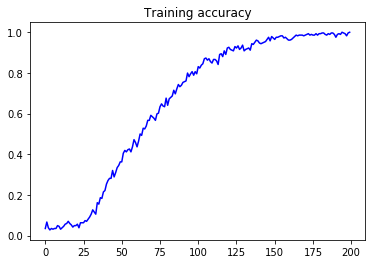

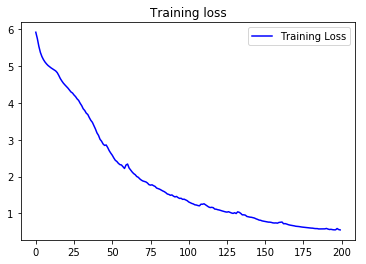

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

Once the model has been trained, we can provide a seed text, and ask the model to complete the sentence by generating text after the seed.

In [12]:
seed_text = "She provided him with"
next_words = 10

In [13]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

She provided him with garret was under the roof of a high five storied


The sentence generated with LSTM is not bad, however probably not better than the one generated by Markov Chain. Let us now modify the LSTM model into a Transformer model by including an Attention layer, and check whether the text generation can be imporved in this case. However, first, we will try to introduce and explain the Attention concept in the next section.

### Explaining and programming Attention mechanism from scratch  <a class="anchor" id="Explaining-and-programming-Attention-mechanism-from-scratch"></a>

The concept of Attention as well as Transformer model was presented for the first time in 2017 at NEURIPS conference as ["Attention is All You Need"](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) article, and later the preprint with more details has been deposited at [Arxive](https://arxiv.org/pdf/1706.03762.pdf).

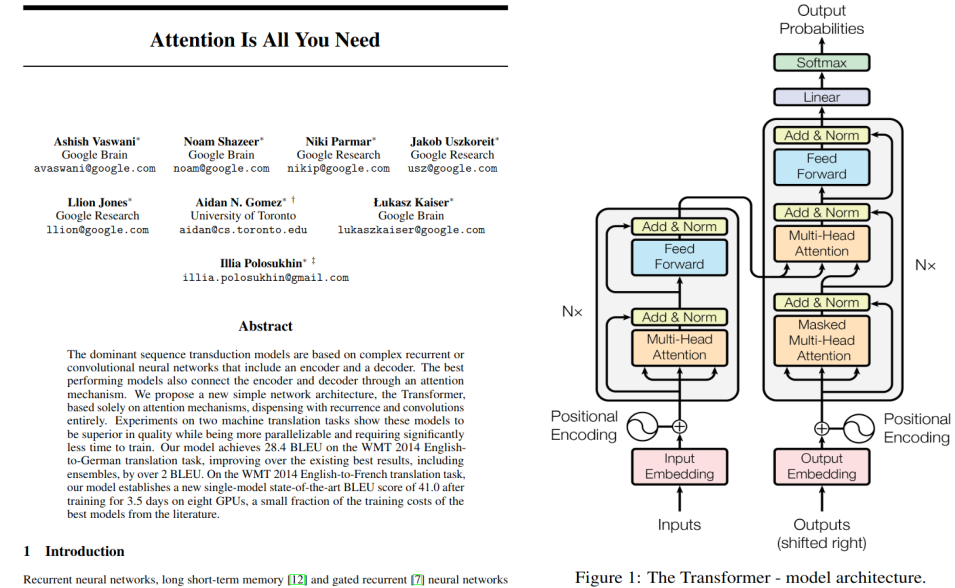

In [63]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/attention_all_you_need.png', width = 1000)

The Attention was claimed to be a special operator (or a layer in a neural network) that could figure out hub-words of **main importance** for each sentence. This allowed to **increase the memory** of the model and account to **longer context in sequential data** such as text or biological sequences (for our case of interest).

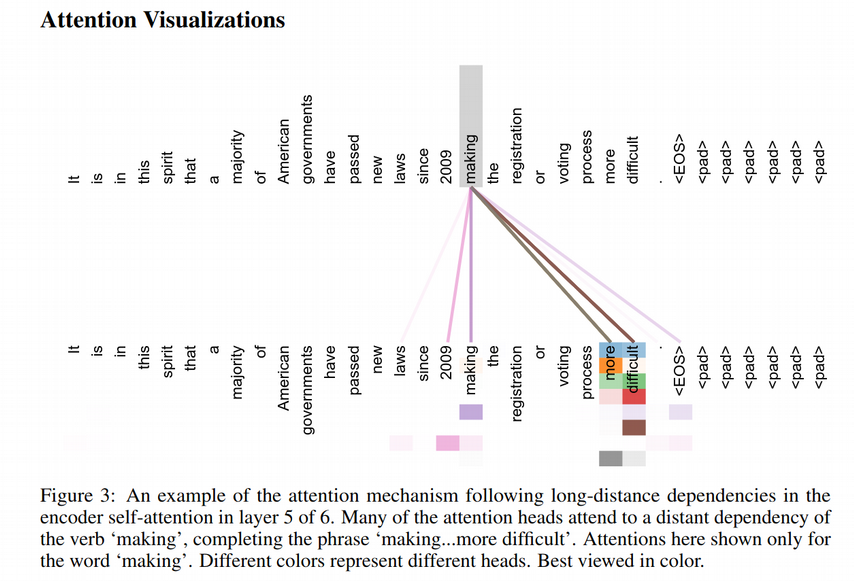

In [4]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/attention_weights.png', width = 1000)

Below, we are going to code a simple variant of Attention algorithm from scratch and explain how, and more importantly, why it should work. The summary below was inspired by materials from [here](https://machinelearningmastery.com/the-attention-mechanism-from-scratch/), [here](https://peterbloem.nl/blog/transformers) and [here](https://twitter.com/hippopedoid/status/1641432291149848576).

Suppose we have a **3D vector representation (3D word embeddings) of 4 words**. Recall from the first section, that words can be converted to vectors of arbitrary dimensions with **Embeddings layer** of a neural network, or pre-trained **Word2Vec** model that can also keep some semantic relationships between the words. Below, we will make up 3D vectors, i.e. 3D word embeddings for 4 words:

In [11]:
import numpy as np

X = np.array([[0, 1, 1], [0, 0, 1], [1, 1, 0], [1, 0, 0]])
X

array([[0, 1, 1],
       [0, 0, 1],
       [1, 1, 0],
       [1, 0, 0]])

Attention is a sequence-to-sequence operation $Y = f (X)$: a sequence of vectors $X$ goes in, and a sequence of vectors $Y$ comes out. To produce output vectors $Y$, the attention operation simply takes a **weighted average over all the input vectors**. Here, however, the weights $W$ are not the parameters for learning but are expressed via the input vectors $X$ themselves. The simplest option for this weights $W$ is the dot product of $X^T$ and $X$, i.e. the covarience of the words. **This allows all words interact with all other words**.

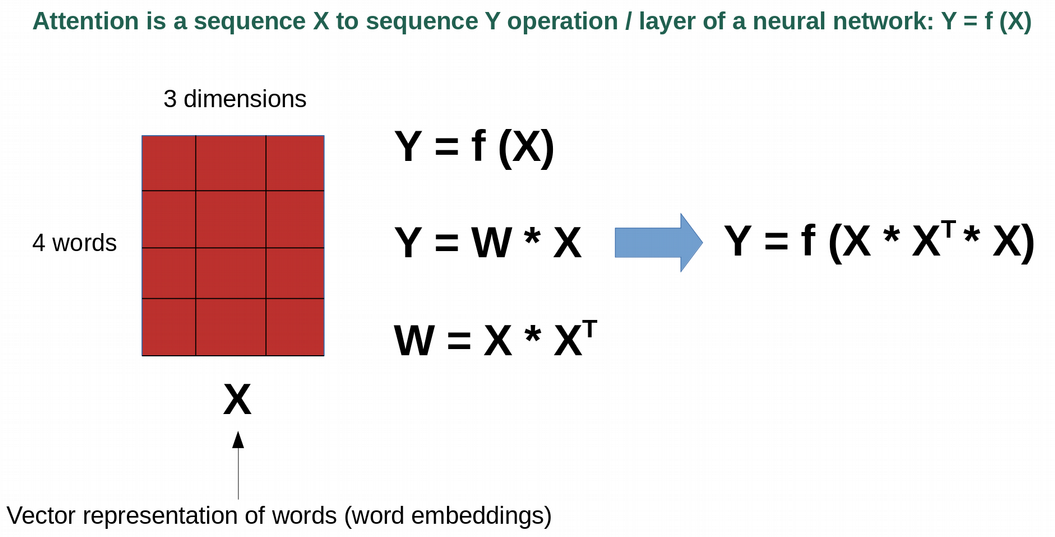

In [8]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/word_embeddings.png', width = 1000)

Now, we need to somehow introduce the parameters to be learnt during training. For this purpose, we are going to build three (3 x 3) matrices $W_Q$, $W_K$ and $W_V$, which we then multiply by the input vectors $X$, $X^T$ and $X$, respectively. The resulting products are called **queries (Q)**, **keys (K)** and **values (V)** using the Attention terminology. Below, I provide the matrix dimensions in the parentences in order to keep track of final dimensionality of the resulting product. The elements of the Q, K and V matrices are the training parameters to be learnt during training:

$$\Large Q(4x3) = X(4x3) * W_Q(3x3)$$

$$\Large K(3x4) = W_K(3x3) * X^T(3x4)$$

$$\Large V(4x3) = X(4x3) * W_V(3x3)$$

Below, we will assign random float values to $W_Q$, $W_K$ and $W_V$, and perform their multiplcation with the data $X$ in order to obtain queries, keys and values. Please note that the dimensions of $W_Q$, $W_K$ and $W_V$ are (3 x 3), i.e. they are square matrices of the size of embedding vectors of the words data X.

In [19]:
W_Q = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
W_K = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
W_V = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])

Q = X @ W_Q
print("Matrix of Queries:")
print(Q)
print("\n")

K = W_K @ X.T
print("Matrix of Keys:")
print(K)
print("\n")

V = X @ W_V
print("Matrix of Values:")
print(V)
print("\n")

Matrix of Queries:
[[1.1 1.3 1.5]
 [0.7 0.8 0.9]
 [0.5 0.7 0.9]
 [0.1 0.2 0.3]]


Matrix of Keys:
[[0.5 0.3 0.3 0.1]
 [1.1 0.6 0.9 0.4]
 [1.7 0.9 1.5 0.7]]


Matrix of Values:
[[1.1 1.3 1.5]
 [0.7 0.8 0.9]
 [0.5 0.7 0.9]
 [0.1 0.2 0.3]]




Now, instead of $X * X^T * X$, after their multiplication by $W_Q$, $W_K$ and $W_V$ (please note that $W_Q$ and $W_V$ multiply $X$ from the right, while $W_K$ multiplies $X^T$ from the left), we will get the product of queries, keys and values as $Q * K * V$. The product of queries and keys $Q * K$ is called **attention weights**. It contains information about how much the words are related to each other.

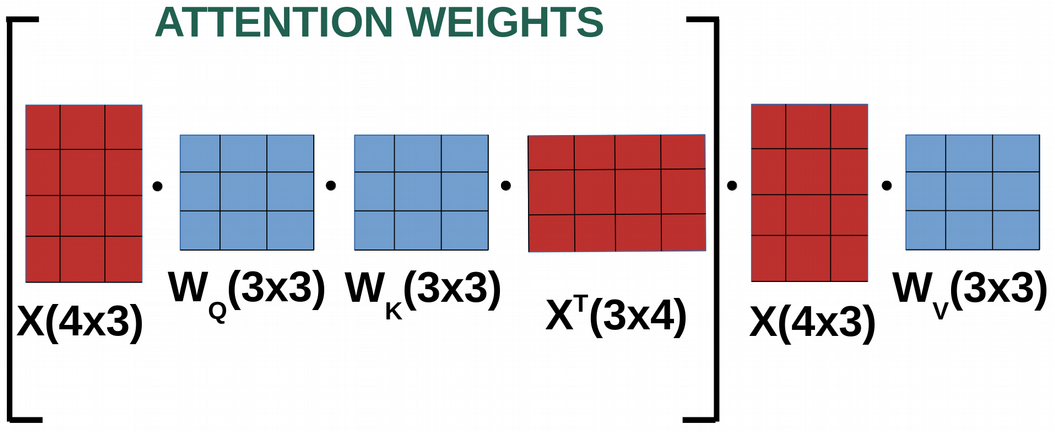

In [20]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/Attention/attention_matrix_mult.png', width = 1000)

The attention weights $Q * K$ are normalized by softmax operation and have the meaning of probabilities after this tranformation.

In [22]:
from scipy.special import softmax
attention_weights = softmax((Q @ K) / K.shape[1] ** 0.5, axis = 1)
attention_weights

array([[0.43998752, 0.15629518, 0.29789658, 0.10582072],
       [0.36520726, 0.19450639, 0.2872822 , 0.15300415],
       [0.35470158, 0.19760633, 0.28751551, 0.16017658],
       [0.28061018, 0.23438532, 0.26426871, 0.22073578]])

Finally, all we need to do is to multiply the attention weights by the transformed $X$ data matrix, which is the matrix of values $V$. The result is a matrix of the same dimension as the initial $X$ data matrix.

In [23]:
attention = attention_weights @ V
attention

array([[0.75292326, 0.92671167, 1.10050008],
       [0.69682397, 0.86207292, 1.02732187],
       [0.68827158, 0.85249329, 1.016715  ],
       [0.62694886, 0.78143675, 0.93592464]])

Therefore, after we have applied Attention operator to data matrix $X$, we have got a matrix of the same dimensions but slightly modified to take into account the **relations between all the words**. Also, as the Attention theory suggests, **more related words have higher weights** which is coded in the final attention matrix.

### Text generation with LSTM  with Attention layer <a class="anchor" id="Text-generation-with-LSTM-with-Attention-layer"></a>

In this section we will demonstrate how to generate text with an LSTM neural network with added Attention layer.

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

In [2]:
tokenizer = Tokenizer()
data = open('crime_and_punishment.txt').read()
corpus = data.lower().split("\n")
corpus = corpus[0:5]
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
corpus

['on an exceptionally hot evening early in july a young man came out of the garret in which he lodged in s. place and walked slowly, as though in hesitation, towards k. bridge.',
 '',
 'he had successfully avoided meeting his landlady on the staircase. his garret was under the roof of a high, five-storied house and was more like a cupboard than a room. the landlady who provided him with garret, dinners, and attendance, lived on the floor below, and every time he went out he was obliged to pass her kitchen, the door of which invariably stood open. and each time he passed, the young man had a sick, frightened feeling, which made him scowl and feel ashamed. he was hopelessly in debt to his landlady, and was afraid of meeting her.',
 '',
 'this was not because he was cowardly and abject, quite the contrary; but for some time past he had been in an overstrained irritable condition, verging on hypochondria. he had become so completely absorbed in himself, and isolated from his fellows that h

In [3]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
input_sequences[0:10]

[[11, 23],
 [11, 23, 34],
 [11, 23, 34, 35],
 [11, 23, 34, 35, 36],
 [11, 23, 34, 35, 36, 37],
 [11, 23, 34, 35, 36, 37, 7],
 [11, 23, 34, 35, 36, 37, 7, 38],
 [11, 23, 34, 35, 36, 37, 7, 38, 8],
 [11, 23, 34, 35, 36, 37, 7, 38, 8, 24],
 [11, 23, 34, 35, 36, 37, 7, 38, 8, 24, 25]]

In [4]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences

array([[  0,   0,   0, ...,   0,  11,  23],
       [  0,   0,   0, ...,  11,  23,  34],
       [  0,   0,   0, ...,  23,  34,  35],
       ...,
       [  0,   0,  92, ..., 159,   3, 160],
       [  0,  92,   6, ...,   3, 160,  16],
       [ 92,   6,  28, ..., 160,  16, 161]], dtype=int32)

In [5]:
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

The architecture of the Transformer neural network is exactly the same as the LSTM model in theprevious section, the only difference is that the attention layer *model.add(SeqSelfAttention())* has been added, which brings more fitting parameters.

In [6]:
import keras
from keras_self_attention import SeqSelfAttention

model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(SeqSelfAttention())
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words / 2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 153, 100)          16200     
_________________________________________________________________
bidirectional (Bidirectional (None, 153, 300)          301200    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 300)         19265     
_________________________________________________________________
dropout (Dropout)            (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 81)                8181      
_________________________________________________________________
dense_1 (Dense)              (None, 162)               1

In [7]:
history = model.fit(predictors, label, epochs = 1000, verbose = 1)

Epoch 1/1000
9/9 [==============================] - 9s 521ms/step - loss: 5.9452 - accuracy: 0.0196
Epoch 2/1000
9/9 [==============================] - 5s 526ms/step - loss: 5.7212 - accuracy: 0.0528
Epoch 3/1000
9/9 [==============================] - 5s 534ms/step - loss: 5.5079 - accuracy: 0.0656
Epoch 4/1000
9/9 [==============================] - 5s 529ms/step - loss: 5.3363 - accuracy: 0.0466
Epoch 5/1000
9/9 [==============================] - 5s 554ms/step - loss: 5.3265 - accuracy: 0.0470
Epoch 6/1000
9/9 [==============================] - 6s 640ms/step - loss: 5.2778 - accuracy: 0.0472
Epoch 7/1000
9/9 [==============================] - 6s 641ms/step - loss: 5.1659 - accuracy: 0.0612
Epoch 8/1000
9/9 [==============================] - 7s 802ms/step - loss: 5.1070 - accuracy: 0.0485
Epoch 9/1000
9/9 [==============================] - 6s 668ms/step - loss: 5.0407 - accuracy: 0.0632
Epoch 10/1000
9/9 [==============================] - 6s 657ms/step - loss: 4.9475 - accuracy: 0.0789

9/9 [==============================] - 6s 665ms/step - loss: 3.7622 - accuracy: 0.1166
Epoch 83/1000
9/9 [==============================] - 6s 634ms/step - loss: 3.7639 - accuracy: 0.0989
Epoch 84/1000
9/9 [==============================] - 6s 663ms/step - loss: 3.7273 - accuracy: 0.1255
Epoch 85/1000
9/9 [==============================] - 6s 661ms/step - loss: 3.7406 - accuracy: 0.0832
Epoch 86/1000
9/9 [==============================] - 6s 665ms/step - loss: 3.7862 - accuracy: 0.0990
Epoch 87/1000
9/9 [==============================] - 6s 614ms/step - loss: 3.8641 - accuracy: 0.1102
Epoch 88/1000
9/9 [==============================] - 6s 660ms/step - loss: 3.8853 - accuracy: 0.0880
Epoch 89/1000
9/9 [==============================] - 6s 699ms/step - loss: 3.8346 - accuracy: 0.0941
Epoch 90/1000
9/9 [==============================] - 6s 636ms/step - loss: 3.7646 - accuracy: 0.1001
Epoch 91/1000
9/9 [==============================] - 6s 656ms/step - loss: 3.7372 - accuracy: 0.0765
Epoc

9/9 [==============================] - 6s 686ms/step - loss: 2.9986 - accuracy: 0.3254
Epoch 163/1000
9/9 [==============================] - 6s 689ms/step - loss: 2.9969 - accuracy: 0.3035
Epoch 164/1000
9/9 [==============================] - 6s 621ms/step - loss: 2.9527 - accuracy: 0.2915
Epoch 165/1000
9/9 [==============================] - 6s 690ms/step - loss: 2.9751 - accuracy: 0.3054
Epoch 166/1000
9/9 [==============================] - 6s 644ms/step - loss: 2.9327 - accuracy: 0.3148
Epoch 167/1000
9/9 [==============================] - 6s 671ms/step - loss: 2.9178 - accuracy: 0.3032
Epoch 168/1000
9/9 [==============================] - 6s 643ms/step - loss: 3.0462 - accuracy: 0.3088
Epoch 169/1000
9/9 [==============================] - 6s 652ms/step - loss: 3.0232 - accuracy: 0.2644
Epoch 170/1000
9/9 [==============================] - 6s 635ms/step - loss: 2.9592 - accuracy: 0.3016
Epoch 171/1000
9/9 [==============================] - 6s 696ms/step - loss: 2.9552 - accuracy: 0.

9/9 [==============================] - 6s 653ms/step - loss: 2.5378 - accuracy: 0.3992
Epoch 243/1000
9/9 [==============================] - 6s 657ms/step - loss: 2.3831 - accuracy: 0.4390
Epoch 244/1000
9/9 [==============================] - 6s 654ms/step - loss: 2.3381 - accuracy: 0.4864
Epoch 245/1000
9/9 [==============================] - 6s 652ms/step - loss: 2.5432 - accuracy: 0.3997
Epoch 246/1000
9/9 [==============================] - 6s 645ms/step - loss: 2.3615 - accuracy: 0.4588
Epoch 247/1000
9/9 [==============================] - 6s 639ms/step - loss: 2.3040 - accuracy: 0.4760
Epoch 248/1000
9/9 [==============================] - 6s 652ms/step - loss: 2.2703 - accuracy: 0.4825
Epoch 249/1000
9/9 [==============================] - 6s 656ms/step - loss: 2.3966 - accuracy: 0.4337
Epoch 250/1000
9/9 [==============================] - 6s 646ms/step - loss: 2.3843 - accuracy: 0.4913
Epoch 251/1000
9/9 [==============================] - 6s 618ms/step - loss: 2.3960 - accuracy: 0.

9/9 [==============================] - 6s 655ms/step - loss: 1.8425 - accuracy: 0.6121
Epoch 323/1000
9/9 [==============================] - 6s 649ms/step - loss: 1.7886 - accuracy: 0.6129
Epoch 324/1000
9/9 [==============================] - 6s 650ms/step - loss: 1.8117 - accuracy: 0.6432
Epoch 325/1000
9/9 [==============================] - 6s 646ms/step - loss: 1.9190 - accuracy: 0.5739
Epoch 326/1000
9/9 [==============================] - 6s 646ms/step - loss: 1.7509 - accuracy: 0.6550
Epoch 327/1000
9/9 [==============================] - 6s 649ms/step - loss: 1.7055 - accuracy: 0.6337
Epoch 328/1000
9/9 [==============================] - 6s 662ms/step - loss: 1.7179 - accuracy: 0.6865
Epoch 329/1000
9/9 [==============================] - 6s 650ms/step - loss: 1.7588 - accuracy: 0.6553
Epoch 330/1000
9/9 [==============================] - 6s 650ms/step - loss: 1.6750 - accuracy: 0.6628
Epoch 331/1000
9/9 [==============================] - 6s 651ms/step - loss: 1.6973 - accuracy: 0.

9/9 [==============================] - 6s 707ms/step - loss: 1.2452 - accuracy: 0.7831
Epoch 403/1000
9/9 [==============================] - 6s 638ms/step - loss: 1.2982 - accuracy: 0.8046
Epoch 404/1000
9/9 [==============================] - 6s 658ms/step - loss: 1.2411 - accuracy: 0.8342
Epoch 405/1000
9/9 [==============================] - 6s 653ms/step - loss: 1.2337 - accuracy: 0.8267
Epoch 406/1000
9/9 [==============================] - 6s 629ms/step - loss: 1.2691 - accuracy: 0.7974
Epoch 407/1000
9/9 [==============================] - 6s 696ms/step - loss: 1.2903 - accuracy: 0.7643
Epoch 408/1000
9/9 [==============================] - 6s 617ms/step - loss: 1.2946 - accuracy: 0.7755
Epoch 409/1000
9/9 [==============================] - 6s 671ms/step - loss: 1.3058 - accuracy: 0.7935
Epoch 410/1000
9/9 [==============================] - 6s 651ms/step - loss: 1.2061 - accuracy: 0.8568
Epoch 411/1000
9/9 [==============================] - 6s 646ms/step - loss: 1.1819 - accuracy: 0.

9/9 [==============================] - 6s 658ms/step - loss: 0.9634 - accuracy: 0.9127
Epoch 483/1000
9/9 [==============================] - 6s 625ms/step - loss: 0.9126 - accuracy: 0.9405
Epoch 484/1000
9/9 [==============================] - 6s 651ms/step - loss: 0.9561 - accuracy: 0.8937
Epoch 485/1000
9/9 [==============================] - 6s 652ms/step - loss: 0.8885 - accuracy: 0.9312
Epoch 486/1000
9/9 [==============================] - 6s 650ms/step - loss: 0.9511 - accuracy: 0.8961
Epoch 487/1000
9/9 [==============================] - 6s 654ms/step - loss: 0.9227 - accuracy: 0.9173
Epoch 488/1000
9/9 [==============================] - 6s 662ms/step - loss: 0.8681 - accuracy: 0.9364
Epoch 489/1000
9/9 [==============================] - 6s 629ms/step - loss: 0.8664 - accuracy: 0.9279
Epoch 490/1000
9/9 [==============================] - 6s 670ms/step - loss: 0.8799 - accuracy: 0.9229
Epoch 491/1000
9/9 [==============================] - 6s 620ms/step - loss: 0.8964 - accuracy: 0.

9/9 [==============================] - 6s 645ms/step - loss: 0.7062 - accuracy: 0.9727
Epoch 563/1000
9/9 [==============================] - 6s 666ms/step - loss: 0.6565 - accuracy: 0.9715
Epoch 564/1000
9/9 [==============================] - 6s 648ms/step - loss: 0.6618 - accuracy: 0.9825
Epoch 565/1000
9/9 [==============================] - 6s 663ms/step - loss: 0.6516 - accuracy: 0.9719
Epoch 566/1000
9/9 [==============================] - 6s 652ms/step - loss: 0.6423 - accuracy: 0.9766
Epoch 567/1000
9/9 [==============================] - 6s 654ms/step - loss: 0.6687 - accuracy: 0.9564
Epoch 568/1000
9/9 [==============================] - 6s 645ms/step - loss: 0.6356 - accuracy: 0.9667
Epoch 569/1000
9/9 [==============================] - 6s 648ms/step - loss: 0.6535 - accuracy: 0.9696
Epoch 570/1000
9/9 [==============================] - 6s 654ms/step - loss: 0.6340 - accuracy: 0.9777
Epoch 571/1000
9/9 [==============================] - 6s 649ms/step - loss: 0.6646 - accuracy: 0.

9/9 [==============================] - 6s 661ms/step - loss: 0.4945 - accuracy: 0.9863
Epoch 643/1000
9/9 [==============================] - 6s 649ms/step - loss: 0.4668 - accuracy: 0.9902
Epoch 644/1000
9/9 [==============================] - 6s 645ms/step - loss: 0.4868 - accuracy: 0.9829
Epoch 645/1000
9/9 [==============================] - 6s 621ms/step - loss: 0.4721 - accuracy: 0.9908
Epoch 646/1000
9/9 [==============================] - 6s 650ms/step - loss: 0.4883 - accuracy: 0.9986
Epoch 647/1000
9/9 [==============================] - 6s 653ms/step - loss: 0.4750 - accuracy: 0.9800
Epoch 648/1000
9/9 [==============================] - 6s 654ms/step - loss: 0.4645 - accuracy: 0.9939
Epoch 649/1000
9/9 [==============================] - 6s 647ms/step - loss: 0.4842 - accuracy: 0.9735
Epoch 650/1000
9/9 [==============================] - 6s 657ms/step - loss: 0.4677 - accuracy: 0.9948
Epoch 651/1000
9/9 [==============================] - 6s 648ms/step - loss: 0.4786 - accuracy: 0.

9/9 [==============================] - 6s 627ms/step - loss: 0.3694 - accuracy: 0.9964
Epoch 723/1000
9/9 [==============================] - 6s 667ms/step - loss: 0.3670 - accuracy: 0.9965
Epoch 724/1000
9/9 [==============================] - 6s 647ms/step - loss: 0.3634 - accuracy: 1.0000
Epoch 725/1000
9/9 [==============================] - 6s 646ms/step - loss: 0.3511 - accuracy: 1.0000
Epoch 726/1000
9/9 [==============================] - 6s 649ms/step - loss: 0.3668 - accuracy: 1.0000
Epoch 727/1000
9/9 [==============================] - 6s 619ms/step - loss: 0.3562 - accuracy: 1.0000
Epoch 728/1000
9/9 [==============================] - 6s 654ms/step - loss: 0.3683 - accuracy: 1.0000
Epoch 729/1000
9/9 [==============================] - 6s 655ms/step - loss: 0.3604 - accuracy: 1.0000
Epoch 730/1000
9/9 [==============================] - 6s 658ms/step - loss: 0.3837 - accuracy: 0.9967
Epoch 731/1000
9/9 [==============================] - 6s 651ms/step - loss: 0.3917 - accuracy: 0.

9/9 [==============================] - 6s 648ms/step - loss: 0.4732 - accuracy: 0.9775
Epoch 803/1000
9/9 [==============================] - 6s 627ms/step - loss: 0.4324 - accuracy: 0.9852
Epoch 804/1000
9/9 [==============================] - 6s 657ms/step - loss: 0.4620 - accuracy: 0.9792
Epoch 805/1000
9/9 [==============================] - 6s 648ms/step - loss: 0.4709 - accuracy: 0.9695
Epoch 806/1000
9/9 [==============================] - 6s 658ms/step - loss: 0.4535 - accuracy: 0.9710
Epoch 807/1000
9/9 [==============================] - 6s 651ms/step - loss: 0.4290 - accuracy: 0.9887
Epoch 808/1000
9/9 [==============================] - 6s 649ms/step - loss: 0.4329 - accuracy: 0.9822
Epoch 809/1000
9/9 [==============================] - 6s 615ms/step - loss: 0.4307 - accuracy: 0.9685
Epoch 810/1000
9/9 [==============================] - 6s 645ms/step - loss: 0.4214 - accuracy: 0.9951
Epoch 811/1000
9/9 [==============================] - 6s 651ms/step - loss: 0.4115 - accuracy: 0.

9/9 [==============================] - 6s 675ms/step - loss: 0.2910 - accuracy: 1.0000
Epoch 883/1000
9/9 [==============================] - 6s 675ms/step - loss: 0.2951 - accuracy: 1.0000
Epoch 884/1000
9/9 [==============================] - 6s 628ms/step - loss: 0.2915 - accuracy: 1.0000
Epoch 885/1000
9/9 [==============================] - 6s 695ms/step - loss: 0.2803 - accuracy: 1.0000
Epoch 886/1000
9/9 [==============================] - 6s 656ms/step - loss: 0.2919 - accuracy: 1.0000
Epoch 887/1000
9/9 [==============================] - 6s 621ms/step - loss: 0.2962 - accuracy: 1.0000
Epoch 888/1000
9/9 [==============================] - 6s 692ms/step - loss: 0.2862 - accuracy: 1.0000
Epoch 889/1000
9/9 [==============================] - 6s 675ms/step - loss: 0.2886 - accuracy: 1.0000
Epoch 890/1000
9/9 [==============================] - 6s 634ms/step - loss: 0.2969 - accuracy: 1.0000
Epoch 891/1000
9/9 [==============================] - 6s 656ms/step - loss: 0.2896 - accuracy: 1.

9/9 [==============================] - 6s 694ms/step - loss: 0.2415 - accuracy: 1.0000
Epoch 963/1000
9/9 [==============================] - 6s 623ms/step - loss: 0.2388 - accuracy: 1.0000
Epoch 964/1000
9/9 [==============================] - 6s 653ms/step - loss: 0.2345 - accuracy: 1.0000
Epoch 965/1000
9/9 [==============================] - 6s 654ms/step - loss: 0.2401 - accuracy: 1.0000
Epoch 966/1000
9/9 [==============================] - 6s 649ms/step - loss: 0.2337 - accuracy: 1.0000
Epoch 967/1000
9/9 [==============================] - 6s 647ms/step - loss: 0.2422 - accuracy: 1.0000
Epoch 968/1000
9/9 [==============================] - 6s 618ms/step - loss: 0.2319 - accuracy: 1.0000
Epoch 969/1000
9/9 [==============================] - 6s 644ms/step - loss: 0.2310 - accuracy: 1.0000
Epoch 970/1000
9/9 [==============================] - 6s 649ms/step - loss: 0.2312 - accuracy: 1.0000
Epoch 971/1000
9/9 [==============================] - 6s 651ms/step - loss: 0.2357 - accuracy: 1.

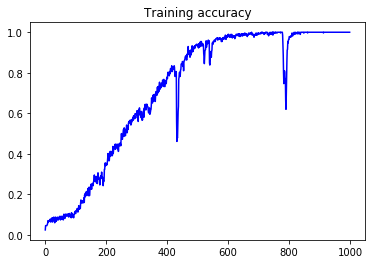

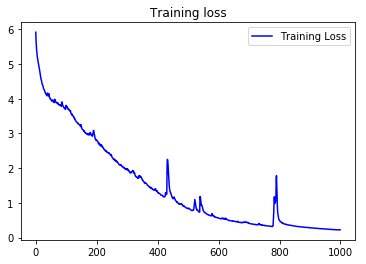

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [16]:
seed_text = "She provided him with"
next_words = 10

In [17]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

She provided him with not because he cowardly and abject quite the contrary but


It seems that including attention did not improve much the LSTM performance.